# ====================================================
# Reconstruction with Multi-Shell Multi-Tissue CSD
# ====================================================

This tutorial is based off the example provided here: https://github.com/dipy/dipy/blob/master/doc/examples/reconst_mcsd.py

This example shows how to fit Multi-Shell Multi-Tissue Constrained Spherical
Deconvolution (MSMT-CSD) using Ray for parallelization. 

In [1]:
import os
import os.path as op

home = op.expanduser("~")
pwd = op.dirname(os.getcwd())

os.environ["TEMPLATEFLOW_HOME"] = op.join(home, "data_", "tractometry")
os.environ["DIPY_HOME"] = op.join(home, "data_", "tractometry")
afq_home = op.join(home, "data_", "tractometry")
os.makedirs(afq_home, exist_ok=True)
os.environ["AFQ_HOME"] = afq_home

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import AFQ.data.fetch as afd

from dipy.core.gradients import gradient_table, unique_bvals_tolerance
from dipy.data import get_sphere
from dipy.denoise.localpca import mppca
import dipy.direction.peaks as dp
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.reconst.mcsd import (
    MultiShellDeconvModel,
    auto_response_msmt,
    mask_for_response_msmt,
    multi_shell_fiber_response,
    response_from_mask_msmt,
)
import dipy.reconst.shm as shm

## Download dataset

We use the fetch function to download a multi-shell dataset provided by Hansen and Jespersen.


In [5]:
sphere = get_sphere(name="symmetric724")
study_dir = afd.fetch_hbn_preproc(["NDARAA948VFH"])[1]
sub_dir = op.join(study_dir, "derivatives/qsiprep/sub-NDARAA948VFH")

fraw = op.join(sub_dir, "ses-HBNsiteRU/dwi/sub-NDARAA948VFH_ses-HBNsiteRU_acq-64dir_space-T1w_desc-preproc_dwi.nii.gz")
fbval = op.join(sub_dir, "ses-HBNsiteRU/dwi/sub-NDARAA948VFH_ses-HBNsiteRU_acq-64dir_space-T1w_desc-preproc_dwi.bval")
fbvec = op.join(sub_dir, "ses-HBNsiteRU/dwi/sub-NDARAA948VFH_ses-HBNsiteRU_acq-64dir_space-T1w_desc-preproc_dwi.bvec")
t1_fname = op.join(sub_dir, "anat/sub-NDARAA948VFH_desc-preproc_T1w.nii.gz")

data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs=bvecs)

## Generate brain mask

We make use of the `median_otsu` method to generate the mask.


In [6]:
b0_mask, mask = median_otsu(data, median_radius=2, numpass=1, vol_idx=[0, 1])


## Generate Anisotropic Power Map


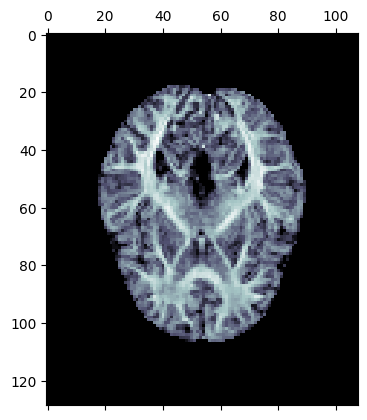

In [12]:
qball_model = shm.QballModel(gtab, 8)
peaks = dp.peaks_from_model(
    model=qball_model,
    data=data,
    relative_peak_threshold=0.5,
    min_separation_angle=25,
    sphere=sphere,
    mask=mask,
)
ap = shm.anisotropic_power(peaks.shm_coeff)
plt.matshow(np.rot90(ap[:, :, 50]), cmap=plt.cm.bone)
plt.show("anisotropic_power_map.png")

In [13]:
plt.close()

## Tissue Classification using HMRF

We use Hidden Markov Random Fields for tissue classification.


In [14]:
nclass = 3
beta = 0.1
hmrf = TissueClassifierHMRF()
initial_segmentation, final_segmentation, PVE = hmrf.classify(ap, nclass, beta)

csf = np.where(final_segmentation == 1, 1, 0)
gm = np.where(final_segmentation == 2, 1, 0)
wm = np.where(final_segmentation == 3, 1, 0)

>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> Iteration: 10
>> Iteration: 11
>> Iteration: 12
>> Iteration: 13
>> Iteration: 14
>> Iteration: 15
>> Iteration: 16
>> Iteration: 17
>> Iteration: 18
>> Iteration: 19
>> Iteration: 20
>> Iteration: 21
>> Iteration: 22
>> Iteration: 23
>> Iteration: 24
>> Iteration: 25
>> Iteration: 26


## Estimate response functions


In [15]:
mask_wm, mask_gm, mask_csf = mask_for_response_msmt(
    gtab,
    data,
    roi_radii=10,
    wm_fa_thr=0.7,
    gm_fa_thr=0.3,
    csf_fa_thr=0.15,
    gm_md_thr=0.001,
    csf_md_thr=0.0032,
)

mask_wm *= wm
mask_gm *= gm
mask_csf *= csf

response_wm, response_gm, response_csf = response_from_mask_msmt(
    gtab, data, mask_wm, mask_gm, mask_csf
)

print(response_wm)
print(response_gm)
print(response_csf)

/Users/john/miniconda3/envs/afq11/lib/python3.11/site-packages/dipy/testing/decorators.py:192: UserWarning: Some b-values are higher than 1200.
        The DTI fit might be affected.
  return func(*args, **kwargs)


[[1.74386067e-03 5.51128649e-04 5.51128649e-04 1.71543289e+02]
 [1.25345421e-03 4.13571330e-04 4.13571330e-04 1.71543289e+02]]
[[1.13012927e-03 9.41805445e-04 9.41805445e-04 2.11726883e+02]
 [8.74253635e-04 7.46203886e-04 7.46203886e-04 2.11726883e+02]]
[[1.23721960e-03 1.13955931e-03 1.13955931e-03 2.72010193e+02]
 [9.32381927e-04 8.68249720e-04 8.68249720e-04 2.72010193e+02]]


## Reconstruction with MSMT-CSD


In [17]:
ubvals = unique_bvals_tolerance(gtab.bvals)
response_mcsd = multi_shell_fiber_response(
    sh_order_max=8,
    bvals=ubvals,
    wm_rf=response_wm,
    gm_rf=response_gm,
    csf_rf=response_csf,
)

mcsd_model = MultiShellDeconvModel(gtab, response_mcsd)
mcsd_fit = mcsd_model.fit(data[:, :, 50:60], engine="ray")

2025-01-24 12:19:55,036	INFO worker.py:1816 -- Started a local Ray instance.
(raylet) [2025-01-24 12:20:03,971 E 19199 182048794] (raylet) file_system_monitor.cc:111: /var/folders/rg/wqvgdwpd2jb1b0vpszd5z2w40000gn/T/tmp4wc0y0zj is over 95% full, available space: 39044329472; capacity: 994662584320. Object creation will fail if spilling is required.
(_parallel_fit_worker pid=19206) /Users/john/miniconda3/envs/afq11/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
(_parallel_fit_worker pid=19206)   warnings.warn(
(_parallel_fit_worker pid=19210) /Users/john/miniconda3/envs/afq11/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
(_parallel_fit_worker pid=19210)   warnings.warn(
(raylet) [2

IndexError: index 50 is out of bounds for axis 2 with size 10

(raylet) [2025-01-24 12:32:59,052 E 19199 182048794] (raylet) file_system_monitor.cc:111: /tmp/ray is over 95% full, available space: 39010025472; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2025-01-24 12:33:09,096 E 19199 182048794] (raylet) file_system_monitor.cc:111: /tmp/ray is over 95% full, available space: 39009628160; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2025-01-24 12:33:19,150 E 19199 182048794] (raylet) file_system_monitor.cc:111: /tmp/ray is over 95% full, available space: 39018905600; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2025-01-24 12:33:29,189 E 19199 182048794] (raylet) file_system_monitor.cc:111: /tmp/ray is over 95% full, available space: 39016677376; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2025-01-24 12:33:39,206 E 19199 182048794] (raylet) file_system_monitor.cc:111: /tmp/ray is over 95% f

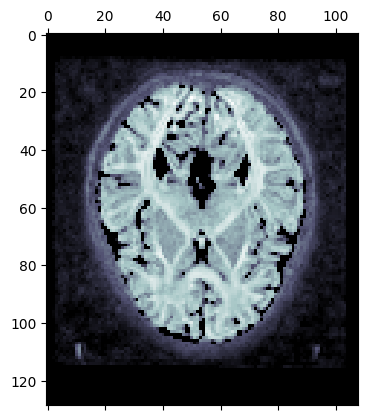

(raylet) [2025-01-24 12:39:30,837 E 19199 182048794] (raylet) file_system_monitor.cc:111: /tmp/ray is over 95% full, available space: 39011897344; capacity: 994662584320. Object creation will fail if spilling is required.


In [18]:
ap = shm.anisotropic_power(mcsd_fit.shm_coeff)
plt.matshow(np.rot90(ap[:, :, 0]), cmap=plt.cm.bone)
plt.show("anisotropic_power_map.png")
plt.close()

## References

- Jeurissen, B., et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 2014.
- Tournier, J-D., et al. "Robust determination of the fibre orientation distribution in diffusion MRI." NeuroImage 2007.
